In [1]:
from google.colab import files
uploaded = files.upload()

Saving train1.csv to train1.csv


In [0]:
import io 
train = pd.read_csv(io.BytesIO(uploaded['train1.csv']))

In [0]:
import numpy as np
import pandas as pd
import time
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_square d_error
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import seaborn as sns

In [6]:
train[:5]

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,...,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,13.0,0.0,0.000000,...,-0.5757,0.0000,-0.4590,-0.6064,-0.2961,0.155800,0.000000,0.000000,0.0,0.000000
1,1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,11.0,2.0,0.181818,...,-0.7260,0.0000,-0.7260,-0.7260,-0.7260,0.000000,1.000000,1.000000,1.0,0.000000
2,2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2.0,0.0,0.000000,...,-0.7000,0.0000,-0.7000,-0.7000,-0.7000,0.000000,0.000000,0.000000,0.0,0.000000
3,3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,0.0,0.0,0.000000,...,-0.5670,0.0808,-0.6640,-0.6650,-0.6630,0.001381,0.833333,0.666667,1.0,0.235702
4,4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,5.0,3.0,0.600000,...,-0.1759,0.1993,-0.5347,-0.6710,-0.3267,0.150600,1.220588,0.941176,1.5,0.395148


In [0]:
target = train['target']
del train['target'] 

In [10]:
train[:5]

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1_mean,hist_category_2_2_mean,...,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,2017-06-01,C_ID_92a2005557,5,2,1,13.0,0.0,0.000000,1.0,0.0,...,-0.5757,0.0000,-0.4590,-0.6064,-0.2961,0.155800,0.000000,0.000000,0.0,0.000000
1,2017-01-01,C_ID_3d0044924f,4,1,0,11.0,2.0,0.181818,1.0,0.0,...,-0.7260,0.0000,-0.7260,-0.7260,-0.7260,0.000000,1.000000,1.000000,1.0,0.000000
2,2016-08-01,C_ID_d639edf6cd,2,2,0,2.0,0.0,0.000000,0.0,0.0,...,-0.7000,0.0000,-0.7000,-0.7000,-0.7000,0.000000,0.000000,0.000000,0.0,0.000000
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.0,0.0,0.000000,0.0,0.0,...,-0.5670,0.0808,-0.6640,-0.6650,-0.6630,0.001381,0.833333,0.666667,1.0,0.235702
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,5.0,3.0,0.600000,0.6,0.0,...,-0.1759,0.1993,-0.5347,-0.6710,-0.3267,0.150600,1.220588,0.941176,1.5,0.395148


In [0]:
del train['Unnamed: 0']

In [0]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_1','feature_2', 'feature_3']

In [0]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [14]:
%%time
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))

start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72511	valid_1's rmse: 3.78598
[200]	training's rmse: 3.65886	valid_1's rmse: 3.73815
[300]	training's rmse: 3.61721	valid_1's rmse: 3.71439
[400]	training's rmse: 3.58799	valid_1's rmse: 3.70094
[500]	training's rmse: 3.5665	valid_1's rmse: 3.69233
[600]	training's rmse: 3.5489	valid_1's rmse: 3.68728
[700]	training's rmse: 3.53363	valid_1's rmse: 3.68378
[800]	training's rmse: 3.5196	valid_1's rmse: 3.68081
[900]	training's rmse: 3.50567	valid_1's rmse: 3.6793
[1000]	training's rmse: 3.49417	valid_1's rmse: 3.67803
[1100]	training's rmse: 3.4823	valid_1's rmse: 3.6768
[1200]	training's rmse: 3.47064	valid_1's rmse: 3.67585
[1300]	training's rmse: 3.46097	valid_1's rmse: 3.67572
[1400]	training's rmse: 3.45058	valid_1's rmse: 3.67524
[1500]	training's rmse: 3.44068	valid_1's rmse: 3.67519
[1600]	training's rmse: 3.43088	valid_1's rmse: 3.67491
[1700]	training's rmse: 3.42213	valid_1's rmse: 3.67471


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.74199	valid_1's rmse: 3.71383
[200]	training's rmse: 3.67418	valid_1's rmse: 3.67025
[300]	training's rmse: 3.63259	valid_1's rmse: 3.65008
[400]	training's rmse: 3.60261	valid_1's rmse: 3.63885
[500]	training's rmse: 3.57993	valid_1's rmse: 3.63285
[600]	training's rmse: 3.5622	valid_1's rmse: 3.62903
[700]	training's rmse: 3.54651	valid_1's rmse: 3.62661
[800]	training's rmse: 3.5323	valid_1's rmse: 3.62478
[900]	training's rmse: 3.51899	valid_1's rmse: 3.62371
[1000]	training's rmse: 3.50691	valid_1's rmse: 3.62248
[1100]	training's rmse: 3.4951	valid_1's rmse: 3.62164
[1200]	training's rmse: 3.48371	valid_1's rmse: 3.62133
[1300]	training's rmse: 3.47338	valid_1's rmse: 3.62088
[1400]	training's rmse: 3.46325	valid_1's rmse: 3.62063
[1500]	training's rmse: 3.45371	valid_1's rmse: 3.62076
[1600]	training's rmse: 3.4445	valid_1's rmse: 3.6208
Early stopping, best iteration is:
[1421]	training's rm

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7461	valid_1's rmse: 3.68865
[200]	training's rmse: 3.67733	valid_1's rmse: 3.64805
[300]	training's rmse: 3.63471	valid_1's rmse: 3.62868
[400]	training's rmse: 3.6042	valid_1's rmse: 3.61836
[500]	training's rmse: 3.58106	valid_1's rmse: 3.6113
[600]	training's rmse: 3.56368	valid_1's rmse: 3.60701
[700]	training's rmse: 3.54783	valid_1's rmse: 3.60439
[800]	training's rmse: 3.53349	valid_1's rmse: 3.60227
[900]	training's rmse: 3.52091	valid_1's rmse: 3.60109
[1000]	training's rmse: 3.50905	valid_1's rmse: 3.60004
[1100]	training's rmse: 3.49784	valid_1's rmse: 3.59937
[1200]	training's rmse: 3.48658	valid_1's rmse: 3.5989
[1300]	training's rmse: 3.47573	valid_1's rmse: 3.59856
[1400]	training's rmse: 3.46563	valid_1's rmse: 3.59807
[1500]	training's rmse: 3.45593	valid_1's rmse: 3.5979
[1600]	training's rmse: 3.44613	valid_1's rmse: 3.59746
[1700]	training's rmse: 3.43761	valid_1's rmse: 3.59743

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.69874	valid_1's rmse: 3.88786
[200]	training's rmse: 3.63176	valid_1's rmse: 3.8414
[300]	training's rmse: 3.59028	valid_1's rmse: 3.81859
[400]	training's rmse: 3.55959	valid_1's rmse: 3.80567
[500]	training's rmse: 3.53681	valid_1's rmse: 3.79865
[600]	training's rmse: 3.518	valid_1's rmse: 3.79433
[700]	training's rmse: 3.50222	valid_1's rmse: 3.79171
[800]	training's rmse: 3.48706	valid_1's rmse: 3.78978
[900]	training's rmse: 3.47412	valid_1's rmse: 3.78827
[1000]	training's rmse: 3.46184	valid_1's rmse: 3.78732
[1100]	training's rmse: 3.44969	valid_1's rmse: 3.78675
[1200]	training's rmse: 3.43857	valid_1's rmse: 3.78634
[1300]	training's rmse: 3.42771	valid_1's rmse: 3.78596
[1400]	training's rmse: 3.41756	valid_1's rmse: 3.78554
[1500]	training's rmse: 3.40743	valid_1's rmse: 3.78563
[1600]	training's rmse: 3.39742	valid_1's rmse: 3.78531
[1700]	training's rmse: 3.38863	valid_1's rmse: 3.785

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.74352	valid_1's rmse: 3.70341
[200]	training's rmse: 3.6751	valid_1's rmse: 3.6629
[300]	training's rmse: 3.63302	valid_1's rmse: 3.64465
[400]	training's rmse: 3.60333	valid_1's rmse: 3.63443
[500]	training's rmse: 3.58074	valid_1's rmse: 3.62837
[600]	training's rmse: 3.5626	valid_1's rmse: 3.62449
[700]	training's rmse: 3.54693	valid_1's rmse: 3.62201
[800]	training's rmse: 3.53331	valid_1's rmse: 3.62033
[900]	training's rmse: 3.52008	valid_1's rmse: 3.61889
[1000]	training's rmse: 3.50758	valid_1's rmse: 3.61824
[1100]	training's rmse: 3.49596	valid_1's rmse: 3.61779
[1200]	training's rmse: 3.48503	valid_1's rmse: 3.61763
[1300]	training's rmse: 3.47468	valid_1's rmse: 3.61726
[1400]	training's rmse: 3.46467	valid_1's rmse: 3.61732
[1500]	training's rmse: 3.45504	valid_1's rmse: 3.61749
Early stopping, best iteration is:
[1325]	training's rmse: 3.47218	valid_1's rmse: 3.61716
CV score: 3.65952 

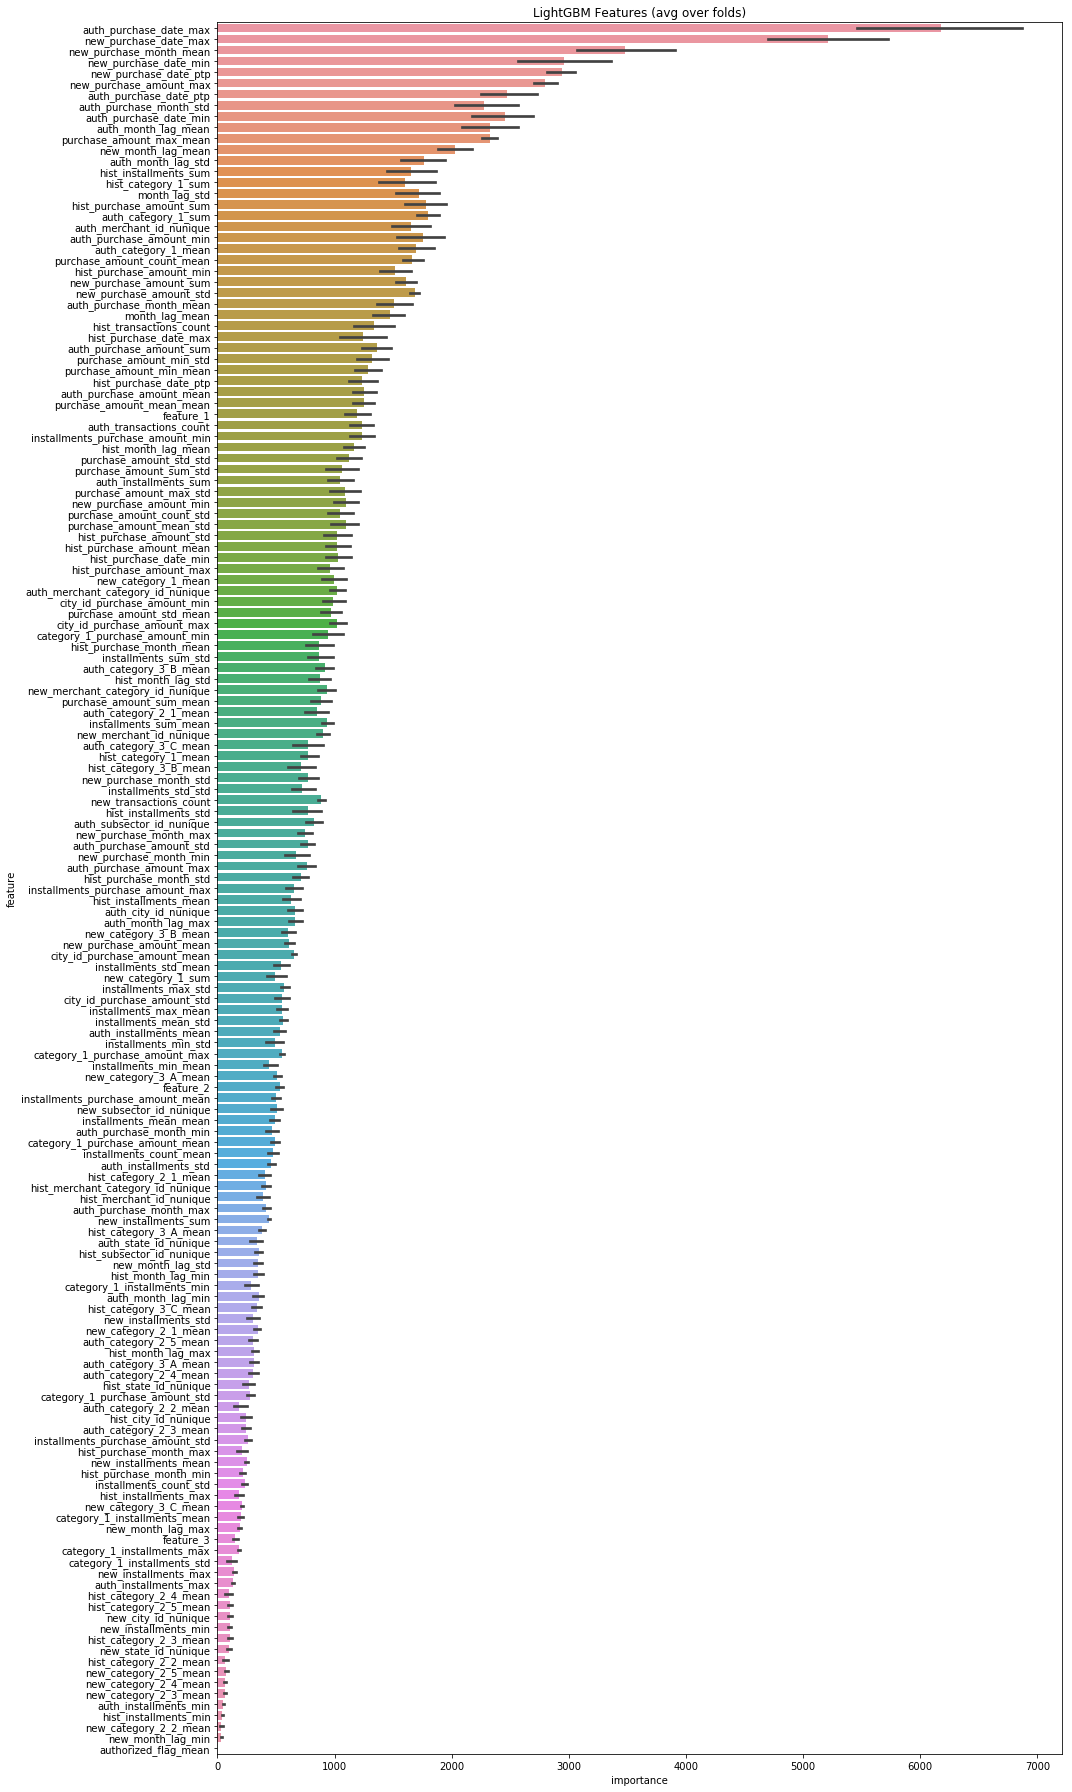

In [20]:
# Feature Importance
plt.figure(figsize=(15,25))
sns.barplot(x="importance",
            y="feature",
            data = feature_importance_df.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()